In [27]:
import pandas as pd

filename_1 = r'./databottle/prices_round_4_day_1.csv'
filename_2 = r'./databottle/prices_round_4_day_2.csv'
filename_3 = r'./databottle/prices_round_4_day_3.csv'

product_1 = "COCONUT"
product_2 = "COCONUT_COUPON"


file_1 = pd.read_csv(filename_1, sep=';')  ## The used separator is ;
file_1_coupon = file_1[file_1['product'] == product_2]
file_1 = file_1[file_1['product'] == product_1]

file_2 = pd.read_csv(filename_2, sep=';')  ## The used separator is ;
file_2_coupon = file_2[file_2['product'] == product_2]
file_2 = file_2[file_2['product'] == product_1]

file_3 = pd.read_csv(filename_3, sep=';')  ## The used separator is ;
file_3_coupon = file_3[file_3['product'] == product_2]
file_3 = file_3[file_3['product'] == product_1]


file_2['timestamp'] = file_2['timestamp'].apply(lambda x: x + 1000000)
file_3['timestamp'] = file_3['timestamp'].apply(lambda x: x + 2000000)

file_2_coupon['timestamp'] = file_2_coupon['timestamp'].apply(lambda x: x + 1000000)
file_3_coupon['timestamp'] = file_3_coupon['timestamp'].apply(lambda x: x + 2000000)


data = pd.concat([file_1, file_2, file_3])  ## Three days merged into 1 frame
data_coupon = pd.concat([file_1_coupon, file_2_coupon, file_3_coupon])

df = pd.DataFrame()

mid_price_product_1 = data['mid_price'].reset_index().drop('index', axis=1)
mid_price_product_2 = data_coupon['mid_price'].reset_index().drop('index', axis=1)


In [28]:
import statistics
import copy
import numpy as np

mid_price_product_1_vol = copy.deepcopy(mid_price_product_1)
#mid_price_product_1_vol.drop('bs_value', axis=1, inplace=True)

mid_price_product_1_vol['log_ret'] = np.log(mid_price_product_1_vol.mid_price) - np.log(mid_price_product_1_vol.mid_price.shift(1))


print(mid_price_product_1_vol['log_ret'].std() * ((((10000)**0.5))*((252)**0.5)))

0.16341161830472062


In [29]:

import math
import numpy as np

def black_scholes_call(S, X, T, r, sigma):
    d1 = (math.log(S / X) + (r + (sigma ** 2) / 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    N_d1 = norm_cdf(d1)
    N_d2 = norm_cdf(d2)
    call_value = S * N_d1 - X * math.exp(-r * T) * N_d2
    return call_value, N_d1

def norm_cdf(x):
    """Cumulative distribution function for the standard normal distribution."""
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0


X = 10000  # Exercise price
T = 250/252  # Time until expiration, in years
r = 0.0  # Risk-free interest rate
sigma = 0.16341161830472062  # Expected annualized volatility

mid_price_product_2['bs_value'] = np.nan
mid_price_product_2['bs_delta'] = np.nan


for idx, price in enumerate(mid_price_product_1['mid_price']):
    mid_price_product_2['bs_value'].iloc[idx], mid_price_product_2['bs_delta'].iloc[idx] = black_scholes_call(price, X, T, r, sigma)


<AxesSubplot:>

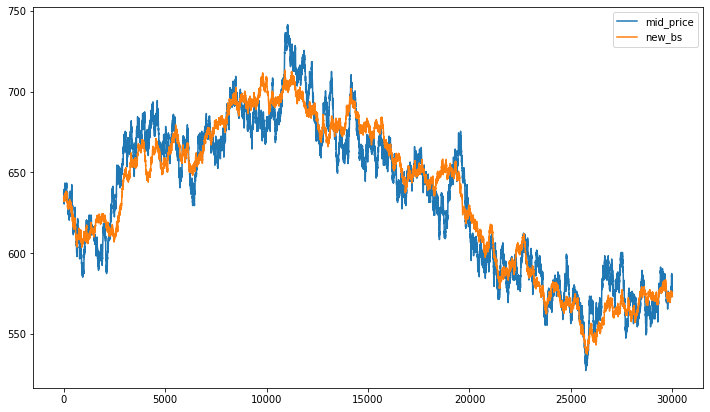

In [30]:

mid_price_product_2['price_diff'] = mid_price_product_2['mid_price'] - mid_price_product_2['bs_value']
mid_price_product_2['new_bs'] = mid_price_product_2['bs_value'] + mid_price_product_2['price_diff'].mean()
mid_price_product_2['price_diff'] = (mid_price_product_2['mid_price'] - mid_price_product_2['new_bs']) / 13.479148432867905

mid_price_product_2[['mid_price', 'new_bs']].plot(figsize=[12, 7])